In [3]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0faaf24b39a5999d89e88da0ad62f4c8b82e265e80859bbe15c8027e918b2c3c
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


In [4]:
from sklearn.model_selection import train_test_split
import wandb
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### DOWNLOADING THE DATASET AND PLOTTING ONE SAMPLE IMAGE FROM EACH CLASS

wandb: Currently logged in as: cs22m078. Use `wandb login --relogin` to force relogin


4422102/4422102 [==============================] - 0s 0us/step


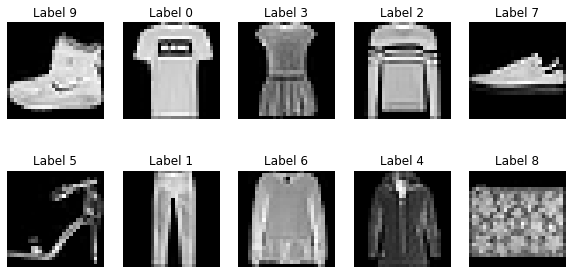

In [6]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="CS6910_Assignment-1",
)

# simulate training
# x_train is a (60000,28,28) matrix consisting image pixels for training
# y_train is a (60000,1) matrix consisting of labels
# x_test is a (10000,28,28) matrix consisting image pixels for testing
# y_test is a (10000,1) matrix consisting of labels for testing
(x_train, y_train), (x_test, y_test) =fashion_mnist.load_data()
#NORMALIZING THE DATASET
x_train=x_train/255.0
x_test=x_test/255.0
labels=set()
i=0
fig,ax=plt.subplots(2,5,figsize=(10,5))
row=0
col=0
for pixels in x_train:
  #The matplotlib function imshow() creates an image from a 2-dimensional numpy array
  #pixels is (28,28) 2-D array
  #l is the current label of image
  l=y_train[i]
  if(not(l in labels)):
    if(col>=5):
      col=0
      row+=1
    ax[row][col].imshow(pixels,cmap="gray")
    ax[row][col].set_title("Label {}".format(l))
    ax[row][col].axis(False)
    labels.add(l)
    col+=1
  #if we get all our 10 labels just break the loop
  if(len(labels)==10):
    break;
  i+=1
wandb.log({"plot":plt})   
# finish the wandb run, necessary in notebooks
wandb.finish()

## DATA-PREPROCESSING

In [7]:
#RESHAPING THE TRAIN_IMAGE DATASET FROM (60000,28x28) TO (60000,784) AND SAME FOR TEST_IMAGE
num_inputs=784
num_outputs=10
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)


#SPLITTING THE TRAINING DATA FOR VALIDATION AND TESTING
train_x,val_x,train_y,val_y=train_test_split(x_train,y_train)
train_x=np.transpose(train_x)
train_y=np.transpose(train_y)
val_x=np.transpose(val_x)
val_y=np.transpose(val_y)

#ONE-HOT ENCODING FOR Y_TRAIN AND Y_TEST: 
exp_y=np.zeros((10,60000))
exp_y_test=np.zeros((10,10000))
for i in range(0,60000):
    exp_y[y_train[i]][i]=1
for i in range(0,10000):
    exp_y_test[y_test[i]][i]=1

#RESHAPING MY DATA TO COLUMN-WISE IMAGES
x_train=x_train.T
x_test=x_test.T
print(x_train.shape)


(784, 60000)


### ACTIVATION FUNCTIONS

In [8]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return np.multiply(s, np.subtract(1, s))

def softmax(x):
    x=x-np.max(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

### INITIALIZING THE PARAMETERS

In [9]:
def initialize_params(hidden_layers,neurons):
  #USING XAVIER INITIALIZATION TO INITIALIZE WEIGHTS AND BIAS MATRIX

  #INDEXING DONE FROM 1
  L=hidden_layers+1 #number of layers excluding hidden layer
  weights=[0]*(hidden_layers+2)
  biases=[0]*(hidden_layers+2)
  previous_updates_W=[0]*(hidden_layers+2)
  previous_updates_B=[0]*(hidden_layers+2)
  np.random.seed(42)
  for i in range(1,hidden_layers+1):
    n=neurons[i]
    # appending the weight and bias matrix for the ith layer
    if(i==1):
      weights[i]=(np.random.randn(n,784)*np.sqrt(2/(n+784)))
      biases[i]=(np.zeros((n,1)))
      previous_updates_W[i]=np.zeros((n,784))
      previous_updates_B[i]=np.zeros((n,1))
      # biases[i]=(np.random.randn(n,1))
    else:
      weights[i]=(np.random.randn(n,neurons[i-1])*np.sqrt(2/(n+neurons[i-1])))
      biases[i]=(np.zeros((n,1)))
      previous_updates_W[i]=np.zeros((n,neurons[i-1]))
      previous_updates_B[i]=np.zeros((n,1))
      # biases[i]=(np.random.randn(n,1))
  weights[L]=(np.random.randn(10,neurons[hidden_layers])*np.sqrt(2/(10+neurons[hidden_layers-1])))
  biases[L]=(np.zeros((10,1)))
  previous_updates_W[L]=np.zeros((10,neurons[hidden_layers]))
  previous_updates_B[L]=np.zeros((10,1))
  weights=np.array(weights,dtype=object)
  biases=np.array(biases,dtype=object)
  previous_updates_W=np.array(previous_updates_W,dtype=object)
  previous_updates_B=np.array(previous_updates_B,dtype=object)
  return weights,biases,previous_updates_W,previous_updates_B

## FEED FORWARD PROPOGATION

In [21]:
def FeedForwardNetwork(weights,biases,L,data):
  #Returns the array containing the output probablity for each class the data can belong
  a=[0]*(L+1)
  h=[0]*(L+1)
  h[0]=data
  for i in range(1,L):
    #weight and bias matrix for hidden-layer i
    weight=weights[i]
    bias=biases[i]
    #pre activation
    a[i]=(bias+np.matmul(weight,h[i-1]))
    #post activation
    h[i]=(sigmoid(a[i]))
  #weight and bias matrix for ouput layer
  weight=weights[L]
  bias=biases[L]
  a[L]=(bias+np.matmul(weight,h[L-1]))
  h[L]=softmax(a[L])
  return h[L],h,a

## BACK PROPOGATION

In [22]:
def BackPropogation(weights,L,H,A,exp_Y,y_hat):
  # Input Parameters of function
  # --> Model Parameters: weights and biases
  # --> H: Post-activations, A: Pre-Activations
  # --> exp_Y: Actual Class Labels
  # Returns list of gradients for each layer wrt weights and biases(parameters)
  gradients_H=[0] * (L+1)
  gradients_W=[0] * (L+1)
  gradients_B=[0] * (L+1)
  gradients_A=[0] * (L+1)
  
  #Computing Gradient For The Output Layer(Pre Activation)
  gradients_A[L]=-(exp_Y-y_hat)
  for k in range(L,0,-1):
    #compute gradients of the parameters
    gradients_W[k]=np.matmul(gradients_A[k],np.transpose(H[k-1]))
    gradients_B[k]=np.sum(gradients_A[k], axis=1,keepdims=True)
    #compute gradients of the hidden layers
    gradients_H[k-1]=np.matmul(np.transpose(weights[k]),gradients_A[k])
    if(k>1):
      gradients_A[k-1]=np.multiply(gradients_H[k-1],sigmoid_derivative(A[k-1]))
    

  return gradients_W,gradients_B

## FUNCTIONS FOR UPDATION OF PARAMETERS

In [98]:
def sgd_params_update(weights,biases,gradients_W,gradients_B,eta):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    weights=weights-eta*(gradients_W)
    biases=biases-eta*(gradients_B)
    return weights,biases



def update_parameters_momentum(weights, biases, gradients_B,gradients_W, beta, previous_updates_W,previous_updates_B,eta,L):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    for i in range(1,L+1):
      previous_updates_W[i]=beta*previous_updates_W[i]+(1-beta)*gradients_W[i]
      previous_updates_B[i]=beta*previous_updates_B[i]+(1-beta)*gradients_B[i]
      weights[i]=weights[i]-eta*previous_updates_W[i]
      biases[i]=biases[i]-eta*previous_updates_B[i]
    return weights,biases,previous_updates_W,previous_updates_B


def update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B,t,L):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    beta1 = 0.9 #default
    beta2 = 0.99 #default
    epsilon = 1e-4 #for numerical stability
    for i in range(1,L+1):

      m_dw=beta1*m_W[i]+(1-beta1)*gradients_W[i]
      v_dw=beta2*v_W[i]+(1-beta2)*np.square(gradients_W[i])
      m_W_hat=m_dw/(1.0 -beta1**t)
      v_W_hat=v_dw/(1.0 -beta2**t)
      weights[i]=weights[i]-(eta*m_W_hat)/np.sqrt(v_W_hat+epsilon)

      m_db=beta1*m_B[i]+(1-beta1)*gradients_B[i]
      v_db=beta2*v_B[i]+(1-beta2)*np.square(gradients_B[i])
      m_B_hat=m_db/(1.0 -beta1**t)
      v_B_hat=v_db/(1.0 -beta2**t)
      biases[i]=biases[i]-(eta*m_B_hat)/np.sqrt(v_B_hat+epsilon)

      v_W[i]=v_dw
      v_B[i]=v_db
      m_W[i]=m_dw
      m_B[i]=m_db


    t=t+1
    return weights,biases,m_W,m_B,v_W,v_B,t


### LEARNING PARAMETERS

In [109]:
def learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size):
  count=1
  predicted_y=[]
  weights,biases,previous_updates_W,previous_updates_B=initialize_params(hidden_layers,neurons)
  L=hidden_layers+1
  t=1
  v_W = previous_updates_W.copy()
  m_W = previous_updates_W.copy()
  v_B = previous_updates_B.copy()
  m_B = previous_updates_B.copy()
  beta=0.9
  while count<=epochs:
      for i in range(0,x_train.shape[1],batch_size):
        mini_batch=x_train[:,i:i+batch_size]
        if learning_algorithm=='nestrov_accelerated_gradient_descent':
          
          W_look_ahead=weights-(beta)*previous_updates_W
          B_look_ahead=biases-(beta)*previous_updates_B
          # print(W_look_ahead[1])
          output,post_act,pre_act=FeedForwardNetwork(W_look_ahead,B_look_ahead,L,mini_batch)
          gradients_W,gradients_B=BackPropogation(W_look_ahead,L,post_act,pre_act,exp_y[:,i:i+batch_size],output)
          weights,biases,previous_updates_W,previous_updates_B=update_parameters_momentum(weights,biases, gradients_B,gradients_W, beta, previous_updates_W,previous_updates_B,eta,L)
        elif learning_algorithm=='nadam':
          W_look_ahead=weights-(beta)*previous_updates_W
          B_look_ahead=biases-(beta)*previous_updates_B
          output,post_act,pre_act=FeedForwardNetwork(W_look_ahead,B_look_ahead,L,mini_batch)
          gradients_W,gradients_B=BackPropogation(W_look_ahead,L,post_act,pre_act,exp_y[:,i:i+batch_size],output)
          weights,biases,m_W,m_B,v_W,v_B,t= update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B, t,L)
        else:
          output,post_act,pre_act=FeedForwardNetwork(weights,biases,L,mini_batch)
          gradients_W,gradients_B=BackPropogation(weights,L,post_act,pre_act,exp_y[:,i:i+batch_size],output)
          if learning_algorithm=='momemtum_gradient_descent':
            weights,biases,previous_updates_W,previous_updates_B=update_parameters_momentum(weights, biases, gradients_B,gradients_W, beta, previous_updates_W,previous_updates_B,eta,L)
          elif learning_algorithm=='stochastic_gradient_descent':
            weights,biases=sgd_params_update(weights,biases,gradients_W,gradients_B,eta)
          elif learning_algorithm=='adam':
            weights,biases,m_W,m_B,v_W,v_B,t= update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B, t,L)          

          
      # print(weights[1])
      full_output,_,_=FeedForwardNetwork(weights,biases,L,x_train)
      predicted_y.append(np.argmax(full_output,axis=0))
      count+=1
  # print(full_output)
  return weights,biases,predicted_y

## **MODEL 1**
---
MOMEMTUM GRADIENT DESCENT


In [14]:
batch_size=512
epochs=10
eta=0.001
learning_algorithm="momemtum_gradient_descent"
hidden_layers=3
neurons=[0,128,128,128]

In [15]:
weights,biases,predicted_y=learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size)

## **MODEL 2**
---
STOCHASTIC GRADIENT DESCENT

In [87]:
batch_size=512
epochs=42
eta=0.001
learning_algorithm="stochastic_gradient_descent"
hidden_layers=3
neurons=[0,128,128,128]

In [ ]:
weights,biases,predicted_y=learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size)

## Model 3

----
Nestrov Accelerated Gradient Descent


In [106]:
batch_size=32
epochs=10
eta=0.01
learning_algorithm="nestrov_accelerated_gradient_descent"
hidden_layers=3
neurons=[0,128,128,128]

In [107]:
weights,biases,predicted_y=learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size)

## Model 4


In [74]:
batch_size=32
epochs=5
eta=0.001
learning_algorithm="adam"
hidden_layers=3
neurons=[0,128,128,128]

In [82]:
weights,biases,predicted_y=learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size)

## Model 4

In [115]:
batch_size=32
epochs=10
eta=0.001
learning_algorithm="nadam"
hidden_layers=3
neurons=[0,128,128,128]

In [116]:
weights,biases,predicted_y=learning_params(hidden_layers,neurons,x_train,y_train,learning_algorithm,eta,epochs,batch_size)

## Checking Accuracy

In [118]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# print(weights)
for i in range(0,len(predicted_y)):
    print("Training accuracy = {} %".format(round(accuracy_score(y_train, predicted_y[i]) * 100, 3)))

Training accuracy = 84.552 %
Training accuracy = 86.522 %
Training accuracy = 87.457 %
Training accuracy = 88.032 %
Training accuracy = 88.405 %
Training accuracy = 88.773 %
Training accuracy = 89.233 %
Training accuracy = 89.553 %
Training accuracy = 89.772 %
Training accuracy = 89.93 %


In [84]:
predicted_y_temp=[]
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
output,post_act,pre_act=FeedForwardNetwork(weights,biases,hidden_layers+1,x_test)
print(output.shape)
predicted_y_temp.append(np.argmax(output,axis=0))
for i in range(0,len(predicted_y_temp)):
    print(predicted_y_temp[i])
    print("Testing accuracy = {} %".format(round(accuracy_score(y_test, predicted_y_temp[i]) * 100, 3)))

(10, 10000)
[9 2 1 ... 8 1 5]
Testing accuracy = 86.55 %
